<a href="https://colab.research.google.com/github/yuzhenke1122/fraud_detection/blob/main/Financial_Anomaly_Detection_and_Risk_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 0. Load Packages

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
!pip install -U imbalanced-learn
# !pip install pandas-profiling
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip


# Part 1. Load Fraud Data and IP Address Data

**fraud_data**: information about each user first transaction

**ip_address**: mapping each numeric ip address to its country. For each country, it gives a range. If the numeric ip address falls within the range, then the ip address belongs to the corresponding country. It is like a look up table.

## fraud_data columns:

**user_id**: id of the user. Unique by user;

**signup_time**: the time when the user created her account (GMT time);

**purchase_time**: the time when the user bought the item (GMT time);

**purchase_value**: the cost of the item purchased (USD);

**device_id**: the device id. You can assume that it is unique by device. i.e., transactions with the same device ID means that the same physical device was used;

**source**: user marketing channel: ads, SEO, Direct (i.e., came to the site by directly typing the site address on the browser);

**browser**: the browser used by the user;

**sex**: user sex: Male/ Female;

**age**: user age;

**ip_address**: user numeric ip address;

**class**: whether the activity was fraudulent (1) or not (0).

## ip_address columns:

**lower_bound_ip_address**: the lower bound of the numeric ip address for that country;

**upper_bound_ip_address**: the upper bound of the numeric ip address for that country;

**country**: the corresponding country. If a user has an ip address whose value is within the upper and lower bound, then she is based in this country.

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Shared link from my google drive
# https://drive.google.com/file/d/1VADsfXvvUYhQfFs0RelXHFepIjMWud-W/view?usp=sharing

id = "1VADsfXvvUYhQfFs0RelXHFepIjMWud-W"
fraud_file = drive.CreateFile({'id': id})
fraud_file.GetContentFile('imbalancedFraudDF.csv')

In [ ]:
# Shared link from my google drive
# https://drive.google.com/file/d/1n-WHOjk1Hrj-PBWBv9HaxIOFhZpLmFQ6/view?usp=sharing

id = "1n-WHOjk1Hrj-PBWBv9HaxIOFhZpLmFQ6"
ip_file = drive.CreateFile({'id': id})
ip_file.GetContentFile('IpAddress_to_Country.csv')

In [ ]:
fraud_data = pd.read_csv('imbalancedFraudDF.csv')
ip_data = pd.read_csv('IpAddress_to_Country.csv')

In [ ]:
fraud_data.head(10)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368.800,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387.866,0
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443.914,0
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117.453,0
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2809315199.927,0
5,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3987484328.519,0
6,360585,2015-04-06 07:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1692458727.649,0
7,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3719094257.187,0
8,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,341674739.580,0
9,199700,2015-07-11 18:26:54,2015-10-28 21:59:40,13,TEPSJVVXGNTYR,Ads,Safari,F,35,1819008577.794,0


In [ ]:
ip_data.head(10)

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.000,16777471,Australia
1,16777472.000,16777727,China
2,16777728.000,16778239,China
3,16778240.000,16779263,Australia
4,16779264.000,16781311,China
5,16781312.000,16785407,Japan
6,16785408.000,16793599,China
7,16793600.000,16809983,Japan
8,16809984.000,16842751,Thailand
9,16842752.000,16843007,China


In [ ]:
fraud_data.shape

(138376, 12)

In [ ]:
ip_data.shape

(138846, 3)

# Part 2. Exploratory Data Analysis

## 2.1 Data Exploration by pandas_profiling

In [ ]:
fraud_data['class'].value_counts()

0    136961
1      1415
Name: class, dtype: int64

In [ ]:
import pandas_profiling

# Summary report without saving report as object
pandas_profiling.ProfileReport(fraud_data)
# It will give warnings on missing, correlation, constant value(0 variance), etc, see http://nbviewer.jupyter.org/github/JosPolfliet/pandas-profiling/blob/master/examples/meteorites.ipynb

# Alternative way for EDA without installing pandas_profiling
# fraud_data.describe().transpose()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 2.2 Check Missing Values and Outliers

In [ ]:
fraud_data.isna().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

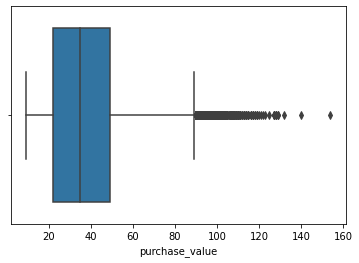

In [ ]:
sns.boxplot(x = fraud_data['purchase_value'])

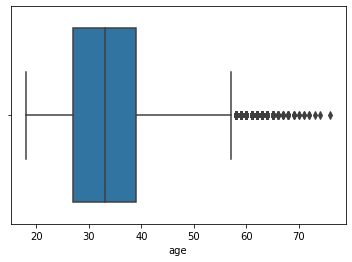

In [ ]:
sns.boxplot(x = fraud_data['age'])

## Identify Country Information Based on ip_address

In [ ]:
ip_data.head(10)

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.000,16777471,Australia
1,16777472.000,16777727,China
2,16777728.000,16778239,China
3,16778240.000,16779263,Australia
4,16779264.000,16781311,China
5,16781312.000,16785407,Japan
6,16785408.000,16793599,China
7,16793600.000,16809983,Japan
8,16809984.000,16842751,Thailand
9,16842752.000,16843007,China


Use O(n) time for each ip_address to find the corresponding country. In this mehtod, the lookup time is about 163.60695 seconds.

In [ ]:
start = time.time()

countries = []
for i in range(len(fraud_data)):
    ip_address = fraud_data.loc[i, 'ip_address']
    tmp = ip_data[(ip_data['lower_bound_ip_address'] <= ip_address) & (ip_data['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA')
        
fraud_data['country'] = countries
runtime = time.time() - start 

print("Lookup took", runtime, "seconds.")

Lookup took 172.85567927360535 seconds.


## Optimization: Using Binary Search

Notice that in the ip_data, the intervals of ip in each row are consecutive and well ordered (ascending). For example, the first 3 ip intervals are [16777216, 16777471], [16777472, 16777727] and [16777728, 16778239], and they are Australia, China and China respectively. Therefore, Binary Search is an optimization in this case. It only cost O(log n) time for searching.

In [ ]:
upper_bound = ip_data['upper_bound_ip_address']

print(type(upper_bound))
print(upper_bound.head())
print(len(upper_bound))

<class 'pandas.core.series.Series'>
0    16777471
1    16777727
2    16778239
3    16779263
4    16781311
Name: upper_bound_ip_address, dtype: int64
138846


## Check the Unique user_id

In [ ]:
print(fraud_data.user_id.nunique()) # 138376
print(len(fraud_data.index)) # 138376

138376
138376


# Part 3a. Feature Engineering (Before Data Spliting)

## 3.1 Time Related Features

Feature engineering on time related features can be done before data spliting the training and test data, because they have no interaction between other rows, only based on other columns of the same row.



**New time related features**:

**interval_after_signup**: the time difference between the sign up and the purchase (in seconds);

**signup_days_of_year**: the days passed in the year at the sign up (in days);

**signup_seconds_of_day**: the seconds passed in the year at the sign up (in seconds);

**purchase_days_of_year**: the days passed in the year at the purchase (in days);

**purchase_seconds_of_day**: the seconds passed in the year at the purchase (in seconds);



In [ ]:
fraud_data['interval_after_signup'] = (pd.to_datetime(fraud_data['purchase_time']) - pd.to_datetime(fraud_data['signup_time'])).dt.total_seconds()

fraud_data['signup_days_of_year'] = pd.DatetimeIndex(fraud_data['signup_time']).dayofyear

fraud_data['signup_seconds_of_day'] = pd.DatetimeIndex(fraud_data['signup_time']).second + 60 * pd.DatetimeIndex(fraud_data['signup_time']).minute + 3600 * pd.DatetimeIndex(fraud_data['signup_time']).hour

fraud_data['purchase_days_of_year'] = pd.DatetimeIndex(fraud_data['purchase_time']).dayofyear

# time of day feature
fraud_data['purchase_seconds_of_day'] = pd.DatetimeIndex(fraud_data['purchase_time']).second + 60 * pd.DatetimeIndex(fraud_data['purchase_time']).minute + 3600 * pd.DatetimeIndex(fraud_data['purchase_time']).hour

fraud_data = fraud_data.drop(['user_id','signup_time','purchase_time'], axis = 1)

In [ ]:
fraud_data.head(10)

,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day
0,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368.800,0,Japan,4506682.000,55,82549,108,10031
1,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387.866,0,United States,17944.000,158,74390,159,5934
2,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443.914,0,NA,492085.000,118,76405,124,50090
3,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117.453,0,United States,4361461.000,202,25792,252,67253
4,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2809315199.927,0,Canada,4240931.000,141,21783,190,29114
5,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3987484328.519,0,NA,2177825.000,213,81652,239,13077
6,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1692458727.649,0,United States,4268729.000,96,27345,145,62474
7,30,ILXYDOZIHOOHT,SEO,IE,F,43,3719094257.187,0,China,3594200.000,111,85114,153,50514
8,62,NRFFPPHZYFUVC,Ads,IE,M,31,341674739.580,0,United States,4943753.000,25,64189,82,83142
9,13,TEPSJVVXGNTYR,Ads,Safari,F,35,1819008577.794,0,United States,9430366.000,192,66414,301,79180


In [ ]:
print(fraud_data.source.value_counts())

SEO       55766
Ads       54913
Direct    27697
Name: source, dtype: int64


Do the transformation of the data (i.e., min-max scaling) after data spliting. Because if transforming all data before scaling, the information in the test data may be leaked. In the real world, the information of the test data should not be known before training/modeling.



# Part 4. Data Spliting

In [ ]:
y = fraud_data['class']
X = fraud_data.drop(['class'], axis=1)

# split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

X_train.shape: (110700, 13)
y_train.shape: (110700,)


In [ ]:
X_train['country'].value_counts(ascending = True)
# drawback: collision in the same bucket(no differentiation for these countries)

Fiji                                        1
Cape Verde                                  1
Tajikistan                                  1
Maldives                                    1
British Indian Ocean Territory              1
Virgin Islands (U.S.)                       1
Dominica                                    1
Gambia                                      1
Madagascar                                  1
Saint Martin                                1
Myanmar                                     1
Niger                                       1
Bhutan                                      1
Guadeloupe                                  1
Bonaire; Sint Eustatius; Saba               1
South Sudan                                 1
Yemen                                       1
San Marino                                  1
Vanuatu                                     1
Burkina Faso                                1
Liechtenstein                               2
Gibraltar                         

In [ ]:
X_train.head(10)

,purchase_value,device_id,source,browser,sex,age,ip_address,country,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day
32048,17,VSFZAHAAGNHGZ,Direct,Opera,M,30,2731645600.077,United States,4943855.000,37,8110,94,27165
51323,40,UWDANNDLUXVEM,Ads,Chrome,F,47,2188012365.506,United States,3645923.000,108,71052,151,1775
72975,26,EUBGPKVFBBLBG,Ads,Safari,M,33,3845301338.404,NA,497650.000,133,8293,138,73943
67796,26,XWGXKQLILXAHB,SEO,Safari,M,38,2427443610.905,United States,3753828.000,112,42423,155,81051
4682,67,MLDIOSIMXBWYX,SEO,Chrome,M,32,1545291119.931,United Kingdom,2151727.000,54,32256,79,23983
124780,58,HTJZMDMZPRSTR,Ads,Opera,F,20,2916833650.769,United States,8586328.000,185,39597,284,72325
110609,42,PZTDFIFEVZETX,Ads,FireFox,M,21,3484535568.476,United States,2138193.000,88,6410,112,71003
128439,30,SOTKEBTBFOIVY,Direct,FireFox,F,26,678008268.490,United States,6505910.000,183,62343,259,1853
19236,31,KHNLRVYZXWDTE,Ads,Chrome,F,22,2425948291.631,United States,4267508.000,78,15788,127,49696
68538,84,LXKDLVQRRENFK,SEO,Safari,M,30,1286173032.834,United States,6793211.000,141,19309,219,73320


# Part 3b. Feature Engineering (After Data Spliting)

## 3.2 Convert Categorical Features with High Cadinality to Numericals

### 3.2.1 Training Data

In [ ]:
# One-Hot Encoding
X_train = pd.get_dummies(X_train, columns = ['source', 'browser']) # Automatically drop sorce and browser columns
X_train['sex'] = (X_train.sex == 'M').astype(int) # Male = 1; Female = 0

In [ ]:
# Frequency Encoding
# Use frequency encoding for device_id, ip_address, and country.

# Linkage Feature: # of accounts on the same device
# The more device_id is shared, the more suspicious. 
# If device_id ABCD occurred 100 times in X_train, then replace all ABCD in device_id col in X_train by 100
X_train_device_id_mapping = X_train.device_id.value_counts(dropna = False)
X_train['n_dev_shared'] = X_train.device_id.map(X_train_device_id_mapping) # number of times device_id occurred in train data

# Device Fingerprint:
# The more a ip_address is shared, the more suspicious.
X_train_ip_address_mapping = X_train.ip_address.value_counts(dropna = False)
X_train['n_ip_shared'] = X_train.ip_address.map(X_train_ip_address_mapping)

# 
# The less visit from a country, the more suspicious.
X_train_country_mapping = X_train.country.value_counts(dropna = False)
X_train['n_country_shared'] = X_train.country.map(X_train_country_mapping) # lots of NAs in country column, # without dropna=False will produce nan in this col

X_train = X_train.drop(['device_id', 'ip_address', 'country'], axis = 1)

### 3.2.2 Test Data

In [ ]:
# One-Hot Encoding
X_test = pd.get_dummies(X_test, columns = ['source', 'browser']) 
X_test['sex'] = (X_test.sex == 'M').astype(int) # Male = 1; Female = 0

In [ ]:
# X_test['n_dev_shared'] = X_test.device_id.map(X_train_device_id_mapping) 

# X_test['n_ip_shared'] = X_test.ip_address.map(X_train_ip_address_mapping)

# X_test['n_country_shared'] = X_test.country.map(X_train_country_mapping)

Notice that the device_id, ip_address has few overlap between the training and test data, so if we apply the above mappings generated from X_train on X_test, most of the X_test will be NaN, as we cannot find the keys in the train mappings. 

If the levels/values/mapping keys of the column in train and test data are pretty much the same (lots of overlap), then we should apply the above 3 X_train_mappings on X_test, rather than using the new mapping generated by X_test.

In [ ]:
# Frequency Encoding
# Use frequency encoding for device_id, ip_address, and country.

# Linkage Feature: # of accounts on the same device
# The more device_id is shared, the more suspicious. 
X_test['n_dev_shared'] = X_test.device_id.map(X_test.device_id.value_counts(dropna = False))

# Device Fingerprint:
# The more a ip_address is shared, the more suspicious.
X_test['n_ip_shared'] = X_test.ip_address.map(X_test.ip_address.value_counts(dropna = False))

# 
# The less visit from a country, the more suspicious.
X_test['n_country_shared'] = X_test.country.map(X_test.country.value_counts(dropna = False))

X_test = X_test.drop(['device_id', 'ip_address', 'country'], axis = 1)

In [ ]:
X_train.head(10)

,purchase_value,sex,age,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,n_dev_shared,n_ip_shared,n_country_shared
32048,17,1,30,4943855.000,37,8110,94,27165,0,1,0,0,0,0,1,0,1,1,42407
51323,40,0,47,3645923.000,108,71052,151,1775,1,0,0,1,0,0,0,0,1,1,42407
72975,26,1,33,497650.000,133,8293,138,73943,1,0,0,0,0,0,0,1,1,1,16285
67796,26,1,38,3753828.000,112,42423,155,81051,0,0,1,0,0,0,0,1,1,1,42407
4682,67,1,32,2151727.000,54,32256,79,23983,0,0,1,1,0,0,0,0,1,1,3250
124780,58,0,20,8586328.000,185,39597,284,72325,1,0,0,0,0,0,1,0,1,1,42407
110609,42,1,21,2138193.000,88,6410,112,71003,1,0,0,0,1,0,0,0,1,1,42407
128439,30,0,26,6505910.000,183,62343,259,1853,0,1,0,0,1,0,0,0,1,1,42407
19236,31,0,22,4267508.000,78,15788,127,49696,1,0,0,1,0,0,0,0,1,1,42407
68538,84,1,30,6793211.000,141,19309,219,73320,0,0,1,0,0,0,0,1,1,1,42407


In [ ]:
X_test.head(10)

,purchase_value,sex,age,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,n_dev_shared,n_ip_shared,n_country_shared
84028,34,1,46,9817743.000,41,52552,155,20695,0,1,0,0,0,1,0,0,1,1,2249
96121,25,0,42,10357988.000,6,31347,126,21335,0,0,1,0,1,0,0,0,1,1,734
33040,36,1,25,9842650.000,130,50801,244,43851,0,0,1,0,0,1,0,0,1,1,74
17883,23,1,29,5357094.000,11,934,73,1228,1,0,0,1,0,0,0,0,1,1,10616
114703,35,0,27,2779010.000,8,71496,40,85706,0,1,0,1,0,0,0,0,1,1,10616
108933,46,1,44,689827.000,62,42919,70,41546,0,0,1,0,0,0,0,1,1,1,10616
119040,15,0,19,4432440.000,115,53643,166,79683,0,1,0,0,0,0,0,1,1,1,10616
109005,40,1,38,5215748.000,44,71101,105,16449,0,0,1,1,0,0,0,0,1,1,734
84250,37,1,22,7917330.000,7,30303,98,85233,1,0,0,0,0,0,1,0,1,1,4006
122420,35,1,24,1580158.000,228,18610,246,43568,0,0,1,1,0,0,0,0,1,1,301


## 3.3 Data Transformation (MinMax Scaling)

Difference between two scaling:

1. Normalization (MinMaxScaler): X - min / max - min; range: [0, 1];

2. Standardization (StandardScaler): x - mean / standard deviation; mu = 0, var = 1; it can be less than 0. 

We use normalization (MinMaxScaler) in this case, because n_dev_shared, n_ip_shared and n_country_shared are frequencies/counts, they are greater than 0. 

In [ ]:
# Create a minmax scaler based on X_train data
scaler = preprocessing.MinMaxScaler().fit(X_train[['n_dev_shared', 'n_ip_shared', 'n_country_shared']]) # scaler has 26 numbers

# Transform the train data
X_train[['n_dev_shared', 'n_ip_shared', 'n_country_shared']] = scaler.transform(X_train[['n_dev_shared', 'n_ip_shared', 'n_country_shared']])

# Apply the same scaler generated by X_train on X_test data.
# Do not use new scaler here.
X_test[['n_dev_shared', 'n_ip_shared', 'n_country_shared']] = scaler.transform(X_test[['n_dev_shared', 'n_ip_shared', 'n_country_shared']])

In [ ]:
X_train.n_dev_shared.value_counts(dropna = False)

0.000    105352
0.250      4850
0.500       375
0.750       108
1.000        15
Name: n_dev_shared, dtype: int64

In [ ]:
X_test.n_dev_shared.value_counts(dropna = False)

0.000    27285
0.250      376
0.500       15
Name: n_dev_shared, dtype: int64

# Part 5. Model Traning

## 5.1 Logistic Regression

In [ ]:
# instantiate the model (using the default parameters)
logistic_regression = LogisticRegression()

# fit the model with data
logistic_regression.fit(X_train, y_train)

# predict on test
y_pred = logistic_regression.predict(X_test)

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred)
cmDF = pd.DataFrame(cm, columns = ['pred_0', 'pred_1'], index = ['true_0', 'true_1'])
print(cmDF)

        pred_0  pred_1
true_0   27408       0
true_1     268       0


## 5.2 Random Forest

In [ ]:
classifier_RF = RandomForestClassifier(random_state = 10)

classifier_RF.fit(X_train, y_train)

# generate class probabilities
probs = classifier_RF.predict_proba(X_test)

predicted = classifier_RF.predict(X_test)

# predict class labels 0/1 for the test set
print("%s: %r" % ("accuracy score is: ", accuracy_score(y_test, predicted)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, probs[:, 1])))
print("%s: %r" % ("f1_score is: ", f1_score(y_test, predicted))) #string to int

print ("confusion_matrix is: ")
cm = confusion_matrix(y_test, predicted)
cmDF = pd.DataFrame(cm, columns = ['pred_0', 'pred_1'], index = ['true_0', 'true_1'])
print(cmDF)
print('recall =', float(cm[1, 1])/(cm[1, 0]+ cm[1, 1])) # recall: the percentage of 1 that is predicted = 150/(150 + 118) = 0.5597
print('precision =', float(cm[1, 1])/(cm[1, 1] + cm[0, 1])) # precision: = 1.0 (false positive = 0)


accuracy score is: : 0.9957363780893193
roc_auc_score is: : 0.7985660712418643
f1_score is: : 0.7177033492822966
confusion_matrix is: 
        pred_0  pred_1
true_0   27408       0
true_1     118     150
recall = 0.5597014925373134
precision = 1.0


## 5.3 SMOTE Sampling

Imbalanced data is problematic: With so few positives relative to negatives, the training model will spend most of its time on negative examples and not learn enough from positive ones. 

Recall - how many relevant instances are selected

Precision - how many selected instances are relevant.

Disadvantage of Undersampling: lose a lot of valuable data.

Disadvantage of Oversampling/Upsampling: creates many duplicate data points.

Synthetic Minority Oversampling Technique, or SMOTE, is a type of data augmentation for minority class in imbalanced datasets. By SMOTE, new samples are synthesized to the existing samples.

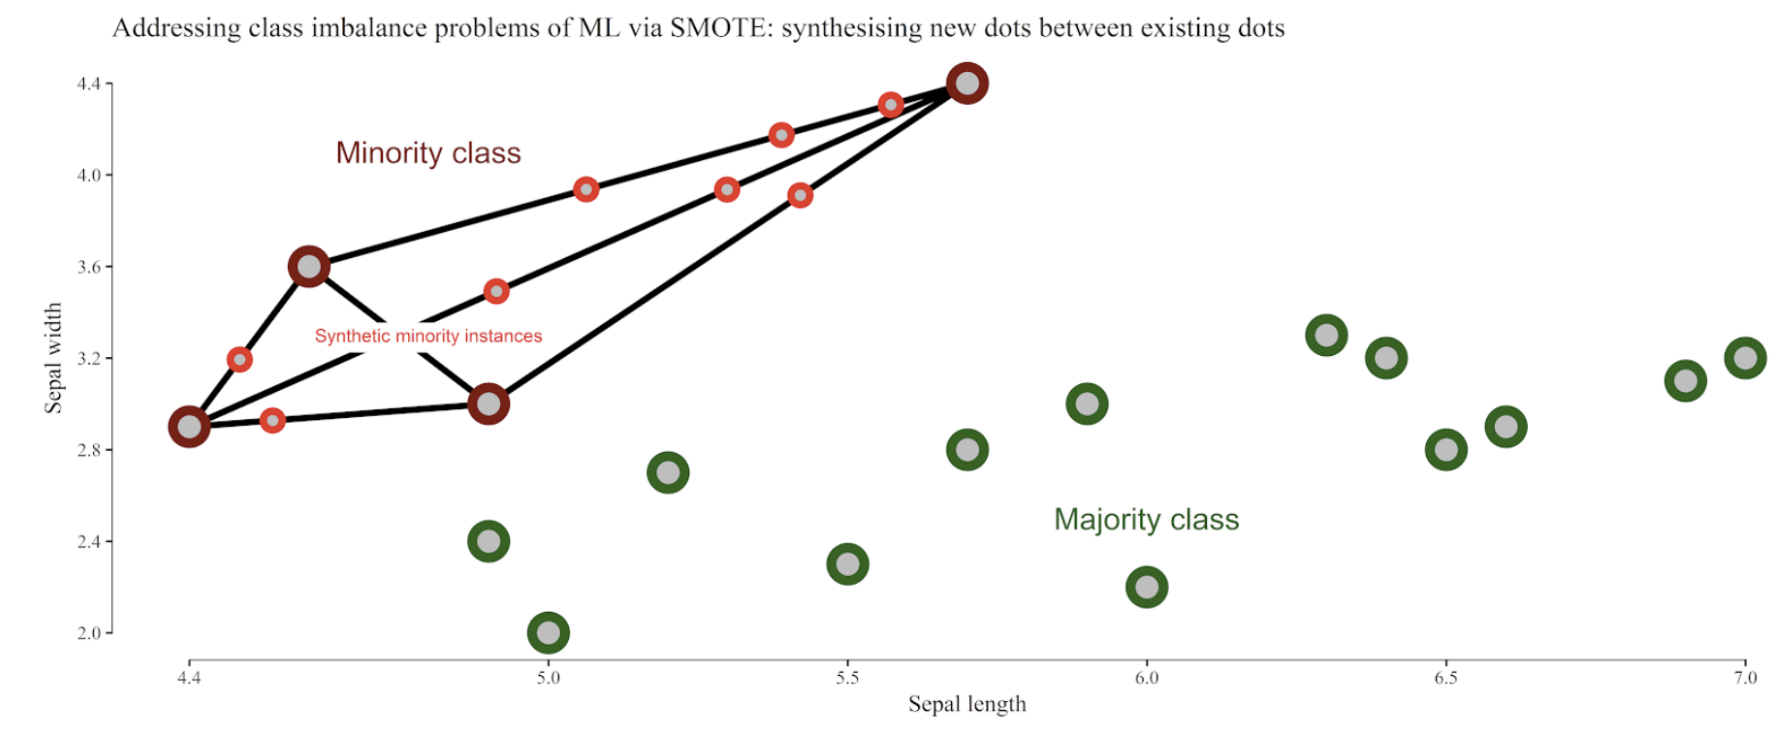

Using SMOTE we can tweak the model to reduce false negatives, at the cost of increasing false positives. The result of using SMOTE is generally an increase in recall, at the cost of lower precision. 

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 11)
x_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

unique, counts = np.unique(y_train_sm, return_counts = True)

print(np.asarray((unique, counts)).T)

[[     0 109553]
 [     1 109553]]


## 5.4 Logistic Regression on SMOTED Training Data

In [ ]:
# fit the model with data
logistic_regression.fit(x_train_sm, y_train_sm)

# predict on test
y_pred_sm = logistic_regression.predict(X_test)

In [ ]:
cm_sm = metrics.confusion_matrix(y_test, y_pred_sm)
cmDF_sm = pd.DataFrame(cm_sm, columns = ['pred_0', 'pred_1'], index = ['true_0', 'true_1'])
print(cmDF_sm)

print('recall =', float(cm_sm[1, 1])/(cm_sm[1, 0]+ cm_sm[1, 1])) # recall: the percentage of 1 that is predicted = 150/(150 + 118) = 0.5597
print('precision =', float(cm_sm[1, 1])/(cm_sm[1, 1] + cm_sm[0, 1])) # precision: = 1.0 (false positive = 0)

        pred_0  pred_1
true_0   19110    8298
true_1      77     191
recall = 0.7126865671641791
precision = 0.022499705501236894


## 5.5 Random Forest on SMOTED Training Data

In [ ]:
classifier_RF_sm = RandomForestClassifier(random_state = 10)

classifier_RF_sm.fit(x_train_sm, y_train_sm)

# predict class labels for the test set
predicted_sm = classifier_RF_sm.predict(X_test)

# generate class probabilities
probs_sm = classifier_RF_sm.predict_proba(X_test)


# generate evaluation metrics
print("%s: %r" % ("accuracy_score_sm is: ", accuracy_score(y_test, predicted_sm)))
print("%s: %r" % ("roc_auc_score_sm is: ", roc_auc_score(y_test, probs_sm[:, 1])))
print("%s: %r" % ("f1_score_sm is: ", f1_score(y_test, predicted_sm )))

print ("confusion_matrix_sm is: ")
cm_sm = confusion_matrix(y_test, predicted_sm)
cmDF = pd.DataFrame(cm_sm, columns = ['pred_0', 'pred_1'], index = ['true_0', 'true_1'])

print(cmDF)
print('recall or sens_sm =',float(cm_sm[1, 1])/(cm_sm[1, 0] + cm_sm[1, 1]))
print('precision_sm =', float(cm_sm[1, 1])/(cm_sm[1, 1] + cm_sm[0, 1]))

#different AUC??

accuracy_score_sm is: : 0.9956641133111721
roc_auc_score_sm is: : 0.7918037603140167
f1_score_sm is: : 0.7142857142857143
confusion_matrix_sm is: 
        pred_0  pred_1
true_0   27406       2
true_1     118     150
recall or sens_sm = 0.5597014925373134
precision_sm = 0.9868421052631579


#Part 6. Parameter Tuning by GridSearchCV

## 6.1 Create a grid_search_wrapper

Use the following 3 different scores for potential refir_score for optimization. (refit on the best model according to the rifit_score)

In [ ]:
# We want to evaluate the following metrics.
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score, pos_label = 1)
    
}

In [ ]:
# GridSearchCV classifier
def grid_search_wrapper(model, parameters, refit_score = 'f1_score'):


    grid_search = GridSearchCV(model, parameters, scoring = scorers, refit = refit_score, cv = 3, return_train_score = True)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)
    y_prob = grid_search.predict_proba(X_test)[:, 1]
    
    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    cm = confusion_matrix(y_test, y_pred)
    cmDF = pd.DataFrame(cm, columns = ['pred_0', 'pred_1'], index = ['true_0', 'true_1'])
    print(cmDF)
    
    print("\t%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, y_prob)))
    print("\t%s: %r" % ("f1_score is: ", f1_score(y_test, y_pred)))

    print('recall = ', float(cm[1, 1]) / (cm[1, 0] + cm[1, 1]))
    print('precision = ', float(cm[1, 1]) / (cm[1, 1] + cm[0, 1]))

    return grid_search

## 6.2 Logistic Regression Using GridSearchCV (f1 score)




In [ ]:
# C: inverse of regularization strength, smaller values specify stronger regularization
LRGrid = {"C" : np.logspace(-2, 2, 5), "penalty": ["l1","l2"]} # l1: lasso; l2: ridge
# param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']} # 0.01 - 100: 10^-2 -- 10^2
logRegModel = LogisticRegression(random_state = 10)

grid_search_LR_f1 = grid_search_wrapper(logRegModel, LRGrid, refit_score = 'f1_score')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

Best params for f1_score
{'C': 0.01, 'penalty': 'l2'}

Confusion matrix of Random Forest optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27408       0
true_1     268       0
	roc_auc_score is: : 0.7714810906065122
	f1_score is: : 0.0
recall =  0.0
precision =  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


## 6.3 Random Forest Using GridSearchCV (f1 score)

In [ ]:
parameters = {
    'max_depth': [None, 5, 15],
    'n_estimators' :  [10, 150],
    'class_weight' : [{0: 1, 1: w} for w in [0.2, 1, 100]] # weight of class 0: 1; weight of class 1: [0.2, 1, 100]
}

clf = RandomForestClassifier(random_state = 10)

In [ ]:
grid_search_rf_f1 = grid_search_wrapper(clf, parameters, refit_score = 'f1_score')

Best params for f1_score
{'class_weight': {0: 1, 1: 100}, 'max_depth': None, 'n_estimators': 10}

Confusion matrix of Random Forest optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27408       0
true_1     118     150
	roc_auc_score is: : 0.7880005347605231
	f1_score is: : 0.7177033492822966
recall =  0.5597014925373134
precision =  1.0


In [ ]:
best_rf_model_f1 = grid_search_rf_f1.best_estimator_
best_rf_model_f1

RandomForestClassifier(class_weight={0: 1, 1: 100}, n_estimators=10,
                       random_state=10)

In [ ]:
results_f1 = pd.DataFrame(grid_search_rf_f1.cv_results_)
results_sortf1 = results_f1.sort_values(by = 'mean_test_f1_score', ascending = False)
results_sortf1[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_f1_score', 'mean_train_precision_score', 'mean_train_recall_score', 'mean_train_f1_score','param_max_depth', 'param_class_weight', 'param_n_estimators']].round(3).head()

,mean_test_precision_score,mean_test_recall_score,mean_test_f1_score,mean_train_precision_score,mean_train_recall_score,mean_train_f1_score,param_max_depth,param_class_weight,param_n_estimators
13,1.000,0.513,0.678,1.000,1.000,1.000,None,"{0: 1, 1: 100}",150
12,1.000,0.513,0.678,1.000,0.865,0.928,None,"{0: 1, 1: 100}",10
0,0.996,0.513,0.677,1.000,0.865,0.928,None,"{0: 1, 1: 0.2}",10
7,0.996,0.513,0.677,1.000,1.000,1.000,None,"{0: 1, 1: 1}",150
11,0.996,0.513,0.677,1.000,0.555,0.714,15,"{0: 1, 1: 1}",150


## 6.4 Logistic Regression Using GridSearchCV (recall score)

In [ ]:
grid_search_LR_recall = grid_search_wrapper(logRegModel, LRGrid, refit_score = 'recall_score')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

Best params for recall_score
{'C': 0.01, 'penalty': 'l2'}

Confusion matrix of Random Forest optimized for recall_score on the test data:
        pred_0  pred_1
true_0   27408       0
true_1     268       0
	roc_auc_score is: : 0.7714810906065122
	f1_score is: : 0.0
recall =  0.0
precision =  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


## 6.5 Random Forest Using GridSearchCV (recall score)

In [ ]:
# Change the refit_score to 'recall_score'
grid_search_rf_recall = grid_search_wrapper(clf, parameters, refit_score = 'recall_score')

Best params for recall_score
{'class_weight': {0: 1, 1: 100}, 'max_depth': 5, 'n_estimators': 150}

Confusion matrix of Random Forest optimized for recall_score on the test data:
        pred_0  pred_1
true_0   27121     287
true_1     104     164
	roc_auc_score is: : 0.8183313130058987
	f1_score is: : 0.4561891515994437
recall =  0.6119402985074627
precision =  0.36363636363636365


In [ ]:
best_rf_model_recall = grid_search_rf_recall.best_estimator_
best_rf_model_recall

RandomForestClassifier(class_weight={0: 1, 1: 100}, max_depth=5,
                       n_estimators=150, random_state=10)

In [ ]:
# Predict class labels for the test set
predictedBest_recall = best_rf_model_recall.predict(X_test)

# Generate class probabilities
probsBest_recall = best_rf_model_recall.predict_proba(X_test)

results_recall = pd.DataFrame(grid_search_rf_recall.cv_results_)# recall score is different from above, as above is metric on test data, this is performance on cv data
results_sortrecall = results_recall.sort_values(by = 'mean_test_recall_score', ascending = False)
results_sortrecall[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_f1_score', 'mean_train_precision_score', 'mean_train_recall_score', 'mean_train_f1_score','param_max_depth', 'param_class_weight', 'param_n_estimators']].round(3).head()
#recall is worse than default rf?? no this is on test, but train recall is better

,mean_test_precision_score,mean_test_recall_score,mean_test_f1_score,mean_train_precision_score,mean_train_recall_score,mean_train_f1_score,param_max_depth,param_class_weight,param_n_estimators
15,0.157,0.626,0.251,0.164,0.648,0.261,5,"{0: 1, 1: 100}",150
14,0.161,0.620,0.256,0.168,0.641,0.266,5,"{0: 1, 1: 100}",10
16,0.721,0.518,0.596,0.836,0.792,0.810,15,"{0: 1, 1: 100}",10
17,0.895,0.515,0.652,0.956,0.810,0.877,15,"{0: 1, 1: 100}",150
1,0.996,0.513,0.677,1.000,1.000,1.000,None,"{0: 1, 1: 0.2}",150


## 6.7 Logistic Regression Using GridSearchCV (precision score)

In [ ]:
grid_search_LR_precision = grid_search_wrapper(logRegModel, LRGrid, refit_score = 'precision_score')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

Best params for precision_score
{'C': 0.01, 'penalty': 'l2'}

Confusion matrix of Random Forest optimized for precision_score on the test data:
        pred_0  pred_1
true_0   27408       0
true_1     268       0
	roc_auc_score is: : 0.7714810906065122
	f1_score is: : 0.0
recall =  0.0
precision =  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


## 6.8 Random Forest Using GridSearchCV (precision score)

In [ ]:
# Change the refit_score to 'recall_score'
grid_search_rf_precision = grid_search_wrapper(clf, parameters, refit_score = 'precision_score')

Best params for precision_score
{'class_weight': {0: 1, 1: 100}, 'max_depth': None, 'n_estimators': 10}

Confusion matrix of Random Forest optimized for precision_score on the test data:
        pred_0  pred_1
true_0   27408       0
true_1     118     150
	roc_auc_score is: : 0.7880005347605231
	f1_score is: : 0.7177033492822966
recall =  0.5597014925373134
precision =  1.0


In [ ]:
best_RF_model_precision = grid_search_rf_precision.best_estimator_
best_RF_model_precision

RandomForestClassifier(class_weight={0: 1, 1: 100}, n_estimators=10,
                       random_state=10)

In [ ]:
# Predict class labels for the test set
predictedBest_precision = best_RF_model_precision.predict(X_test)

# Generate class probabilities
probsBest_precision = best_RF_model_precision.predict_proba(X_test)

results_precision = pd.DataFrame(grid_search_rf_precision.cv_results_)
results_sortprecision = results_recall.sort_values(by = 'mean_test_precision_score', ascending = False)
results_sortprecision[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_f1_score', 'mean_train_precision_score', 'mean_train_recall_score', 'mean_train_f1_score','param_max_depth', 'param_class_weight', 'param_n_estimators']].round(3).head()

,mean_test_precision_score,mean_test_recall_score,mean_test_f1_score,mean_train_precision_score,mean_train_recall_score,mean_train_f1_score,param_max_depth,param_class_weight,param_n_estimators
13,1.000,0.513,0.678,1.000,1.000,1.000,None,"{0: 1, 1: 100}",150
12,1.000,0.513,0.678,1.000,0.865,0.928,None,"{0: 1, 1: 100}",10
0,0.996,0.513,0.677,1.000,0.865,0.928,None,"{0: 1, 1: 0.2}",10
7,0.996,0.513,0.677,1.000,1.000,1.000,None,"{0: 1, 1: 1}",150
11,0.996,0.513,0.677,1.000,0.555,0.714,15,"{0: 1, 1: 1}",150


# Part 7. Feature Importance

In [ ]:
# Feature Importance
pd.DataFrame(best_rf_model_f1.feature_importances_, index = X_train.columns, columns = ['importance']).sort_values('importance', ascending = False)

,importance
interval_after_signup,0.194
purchase_days_of_year,0.192
n_dev_shared,0.130
signup_days_of_year,0.095
purchase_seconds_of_day,0.079
signup_seconds_of_day,0.079
purchase_value,0.068
age,0.060
n_country_shared,0.043
sex,0.009


In [ ]:
trainDF = pd.concat([X_train, y_train], axis = 1)
pd.crosstab(trainDF["n_dev_shared"], trainDF["class"])

class,0,1
n_dev_shared,,
0.000,104893,459
0.250,4460,390
0.500,167,208
0.750,30,78
1.000,3,12


In [ ]:
fraud_data.groupby("class")[['interval_after_signup']].mean()

,interval_after_signup
class,
0,5191178.589
1,2570226.486


In [ ]:
fraud_data.groupby("class")[['interval_after_signup']].median()
# Important! Class 1 have median of 1 but class 0 has median of much larger time interval.

,interval_after_signup
class,
0,5194911.000
1,1.000


In [ ]:
fraud_data[fraud_data['class'] == 1].head(100)

,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day
136961,24,VLHGCDPFCICDA,SEO,Chrome,F,33,3432126053.974,1,United States,3327952.000,218,80113,257,38465
136962,14,YLUQSRNYYIPXU,Ads,Chrome,M,40,3905319222.432,1,NA,1.000,12,4207,12,4208
136963,63,ABUBCQDATQMQH,Ads,FireFox,F,46,550567048.828,1,United States,7640070.000,49,40723,137,77593
136964,34,QHEODGCAVJKIQ,SEO,Chrome,M,37,940809573.076,1,United States,1.000,12,77710,12,77711
136965,76,DAKVYHKIEYRBH,SEO,Chrome,F,48,636104095.166,1,Hungary,1.000,10,48421,10,48422
136966,32,ESANFBTIVMNHX,Ads,IE,M,30,3875475185.465,1,NA,5721252.000,176,53824,242,72676
136967,95,HIAMXITLJWYCT,SEO,FireFox,M,42,3786924254.196,1,NA,10160108.000,9,33511,126,84819
136968,13,BQTPLJBGYXQYX,Ads,IE,M,32,2463261847.588,1,Austria,1.000,12,29576,12,29577
136969,15,BWSMVSLCJXMCM,Direct,IE,F,39,2937899119.500,1,Japan,1.000,7,61065,7,61066
136970,26,HPPSDIRGUSSTB,Direct,Opera,M,31,647126142.838,1,United States,1.000,1,80617,1,80618


# Part 8. Actionable Recommendation

In [ ]:
# First column: probability of being non-fraud; Second column: probability of being fraud.
t = (10 * probsBest_recall[:, 1]).astype(int) # t is an array of integers, range of t: [0, 10]
unique, counts = np.unique(t, return_counts = True)

print(np.asarray((unique, counts)).T)

# 9: raw probability > 0.9.
# It means that the probability of this transaction being fraud is at least 0.9, we can put it in a red flag.

[[    2 20747]
 [    3  6389]
 [    4    89]
 [    5   202]
 [    6    99]
 [    7     1]
 [    8    24]
 [    9   125]]


The integers above indicate the probability of this transaction being fraud. For example, the integer 9 means that the probability of this traction being fraud is at least 90%. We can set different intervals and apply different actions for different intervals. For example, if the probability of a transaction falls into [1, 3], we mark a green flag on this transaction and pass it. If the probability of a transaction falls into[4, 7] interval, then we mark a grey flag on this transaction and consider it as potential fraud. We can check this suspicious transaction manually by calling the customers to varify whether it is a real fraud. Finally, if the probability of a transaction falls into [8, 9] interval, we can mark it as a red flag and decline this transaction because there is a very high probability that it is being a fraud.